# Generation Latency

### Table of Contents
* [Complete Workflow (Exp 2) as Baseline](#Complete-Workflow-(Exp-2)-as-Baseline)
* [LR1: Using Rank-128 Quantized (`fp16`) LoRA ControlNet Models](#LR1:-Using-Rank-128-Quantized-(fp16)-LoRA-ControlNet-Models)
* [LR2: Using **Pruned** SD1.5 checkpoint](#LR2:-Using-**Pruned**-SD1.5-checkpoint)
* [LR3: Reducing the number of sampling steps](#LR3:-Reducing-the-number-of-sampling-steps)
* [Takeways](#Takeaways)


For this task, I installed the [ComfyUI Profiler plugin](https://github.com/tzwm/comfyui-profiler) and used Experiment 2's [workflow](./workflows/1_experiments/1_experiments_exp2_workflow.png) from [`1_experiments.ipynb`](./1_experiments.ipynb). My initial idea was to use the [ComfyUI to Python Extension](https://github.com/pydn/ComfyUI-to-Python-Extension) to convert to Python code and attach profilers on individual components (which would allow multiple identical trials to obtain standard deviations). However, the extension was unable to convert that workflow to code (see "Limitations" below). Therefore, I resorted to manually collecting the timings provided by the profiler plugin. Note that these timings only include the time taken by the ControlNet models, the SD sampler and the VAE decoder, as the CLIP Encoders and ControlNet Preprocessors are identical across runs.

* Configuration used:
    * Workflow: [Experiment 2](./workflows/1_experiments/1_experiments_exp2_workflow.png)
    * Depth-map input: [`5_G.png`](./metadata/images/grayscale/5_G.png)
* Iterative strategies employed to reduce latency:
    * LR1: Using smaller, quantized (`fp16`) models (Rank-128 LoRA) from [here](https://huggingface.co/comfyanonymous/ControlNet-v1-1_fp16_safetensors/tree/main)
    * LR2: Using the **pruned** SD1.5 checkpoint instead of the larger checkpoint (used so far)
    * LR3: Reducing the number of sampling steps

Note that, simply detaching the less-relevant ControlNet preprocessors would also lead to a reduction in latency. But I chose to keep them in the workflow for the sake of consistency with respect to prior experiments.

#### Some limitations to note:
* ComfyUI caches prior results & models, making successive identical runs to obtain statistics difficult. Here, I have reported cold-start times (restarting ComfyUI, clearing cache and re-running the workflow).
* The Profiler plugin is unstable and crashes frequently for the chosen (admittedly, complicated) workflow ([See Image](./errors/err_prof.png)).
* The `ComfyUI-to-Python-Extension` was unable to convert the workflow to code ([See Command Log](./errors/exp2_to_code_conversion.log)).

In [7]:
from pathlib import Path
from matplotlib import pyplot as plt

# Local imports
from utils import display_results

# `display_results` is a function that reads and displays results of a ComfyUI experiment

exp_root = Path("./results/3_gen_latency")

## Complete Workflow (Exp 2) as Baseline
For the complete workflow, the timings are as follows:

| Process                                        | Time (seconds) |
|:-----------------------------------------------|:--------------:|
| CheckpointLoaderSimple                         | 2.9391         |
| ControlNetLoader                               | 0.2651         |
| ControlNetApplyAdvanced                        | 0.0013         |
| CR Multi-ControlNet Stack                      | 0.9322         |
| CR Multi-ControlNet Stack                      | 1.2387         |
| CR Apply Multi-ControlNet                      | 0.001          |
| KSamplerAdvanced                               | 6.5851         |
| VAEDecode                                      | 0.2016         |

The image quality analysis is given below:

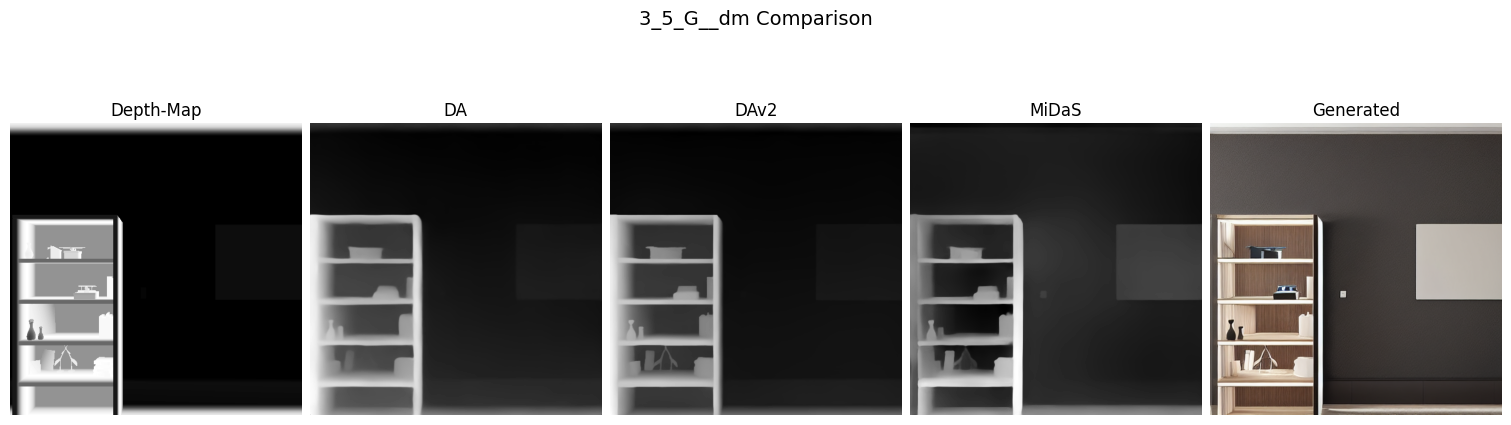

                 Quantitative Metrics                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃                 3_5_G__dm                 ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS  │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━│
│ NRMSE ↓ │     0.659     │      0.690       │ 0.736  │
│ SSIM ↑  │     0.233     │      0.238       │ 0.136  │
│ PSNR ↑  │    11.920     │      11.517      │ 10.955 │
│MANIQA ↑ │                   0.409                   │
└─────────┴───────────────────────────────────────────┘

In [8]:
display_results(exp_root, exp_name="complete")

## LR1: Using Rank-128 Quantized (`fp16`) LoRA ControlNet Models

| Process                                        | Time (seconds) |
|:-----------------------------------------------|:--------------:|
| CheckpointLoaderSimple                         | 3.0391         |
| ControlNetLoader                               | 0.0643         |
| ControlNetApplyAdvanced                        | 0.0013         |
| CR Multi-ControlNet Stack                      | 0.2258         |
| CR Multi-ControlNet Stack                      | 0.231          |
| CR Apply Multi-ControlNet                      | 0.001          |
| KSamplerAdvanced                               | 8.8234         |
| VAEDecode                                      | 0.1934         |

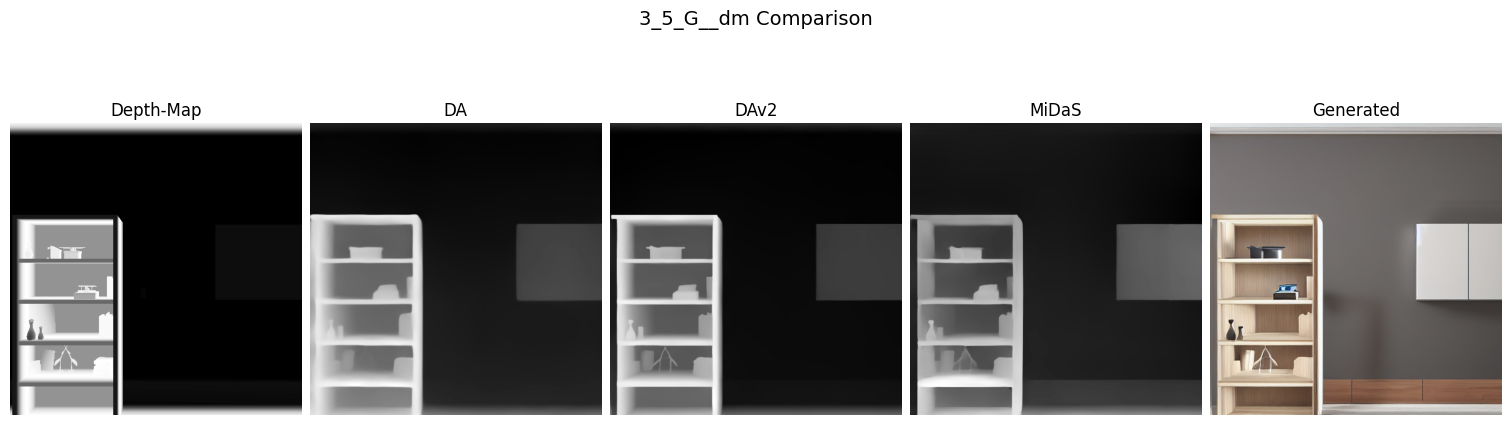

                 Quantitative Metrics                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃                 3_5_G__dm                 ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS  │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━│
│ NRMSE ↓ │     0.613     │      0.577       │ 0.611  │
│ SSIM ↑  │     0.216     │      0.322       │ 0.185  │
│ PSNR ↑  │    12.549     │      13.068      │ 12.577 │
│MANIQA ↑ │                   0.464                   │
└─────────┴───────────────────────────────────────────┘

In [9]:
display_results(exp_root, exp_name="fp16+lora")

## LR2: Using **Pruned** SD1.5 checkpoint

| Process                                        | Time (seconds) |
|:-----------------------------------------------|:--------------:|
| CheckpointLoaderSimple                         | 1.5229         |
| ControlNetLoader                               | 0.004          |
| ControlNetApplyAdvanced                        | 0.0008         |
| CR Multi-ControlNet Stack                      | 0.0109         |
| CR Multi-ControlNet Stack                      | 0.0108         |
| CR Apply Multi-ControlNet                      | 0.0006         |
| KSamplerAdvanced                               | 4.8964         |
| VAEDecode                                      | 0.104          |

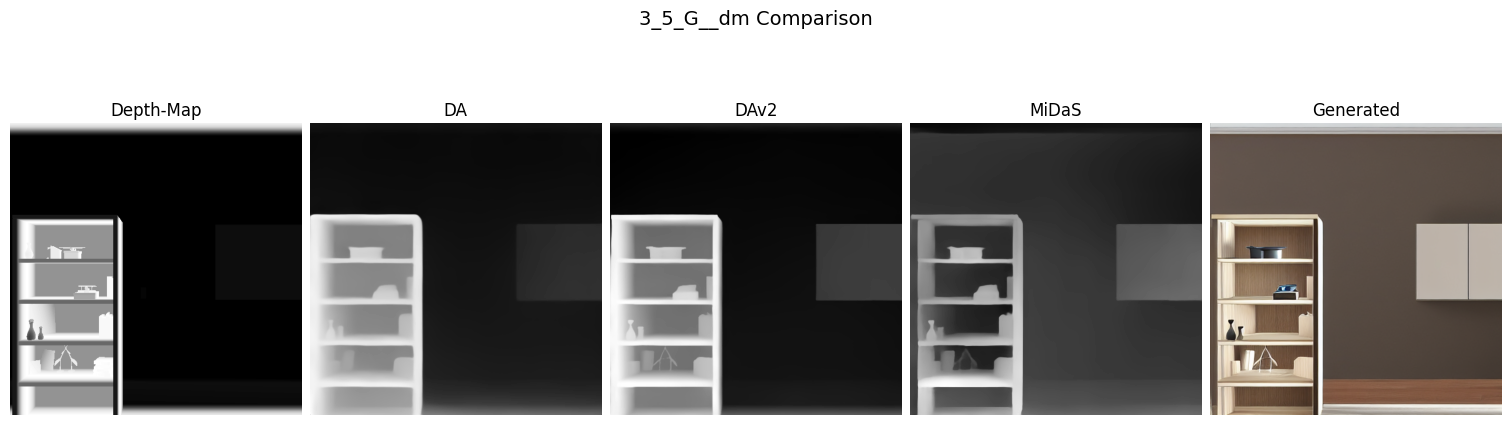

                 Quantitative Metrics                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃                 3_5_G__dm                 ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS  │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━│
│ NRMSE ↓ │     0.603     │      0.632       │ 0.754  │
│ SSIM ↑  │     0.210     │      0.263       │ 0.133  │
│ PSNR ↑  │    12.685     │      12.277      │ 10.751 │
│MANIQA ↑ │                   0.441                   │
└─────────┴───────────────────────────────────────────┘

In [10]:
display_results(exp_root, exp_name="pruned")

## LR3: Reducing the number of sampling steps

Here, I tried 2, 4, 8, 16, 32, 64 sampling steps. `LR1` & `LR2` were applied. As such, only the sampler (`KSamplerAdvanced`) timings are reported. The results are as follows:


| Steps | Time (s) |
|-------|----------|
| 2     | 0.8021   |
| 4     | 1.2106   |
| 8     | 2.1438   |
| 16    | 3.6635   |
| 32    | 7.0857   |
| 64    | 13.6803  |

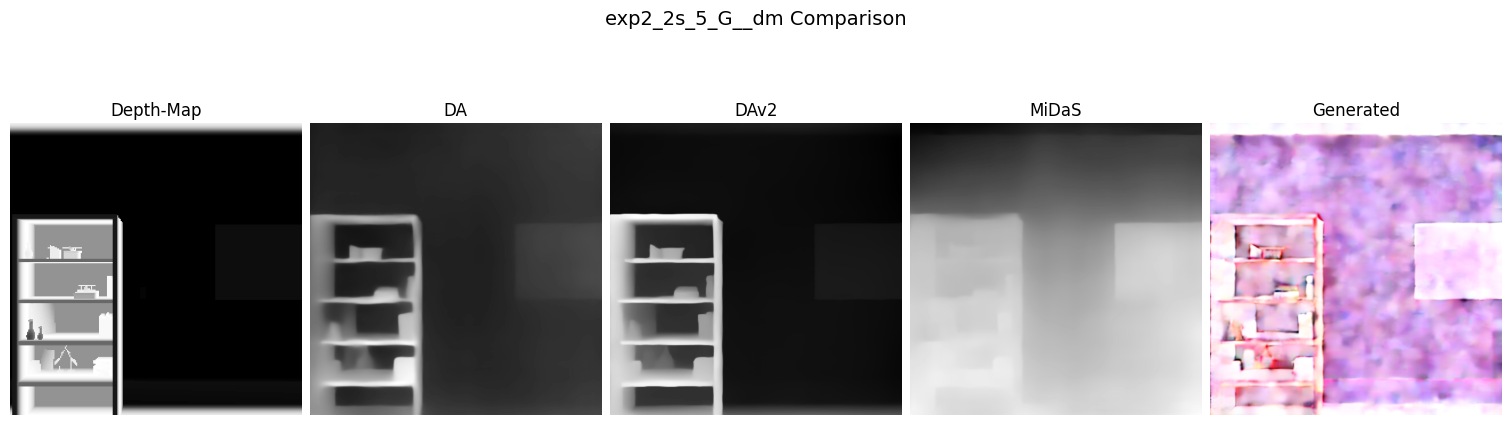

                 Quantitative Metrics                 
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃             exp2_2s_5_G__dm              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━│
│ NRMSE ↓ │     0.725     │      0.669       │ 1.394 │
│ SSIM ↑  │     0.127     │      0.238       │ 0.136 │
│ PSNR ↑  │    11.084     │      11.778      │ 5.406 │
│MANIQA ↑ │                  0.179                   │
└─────────┴──────────────────────────────────────────┘

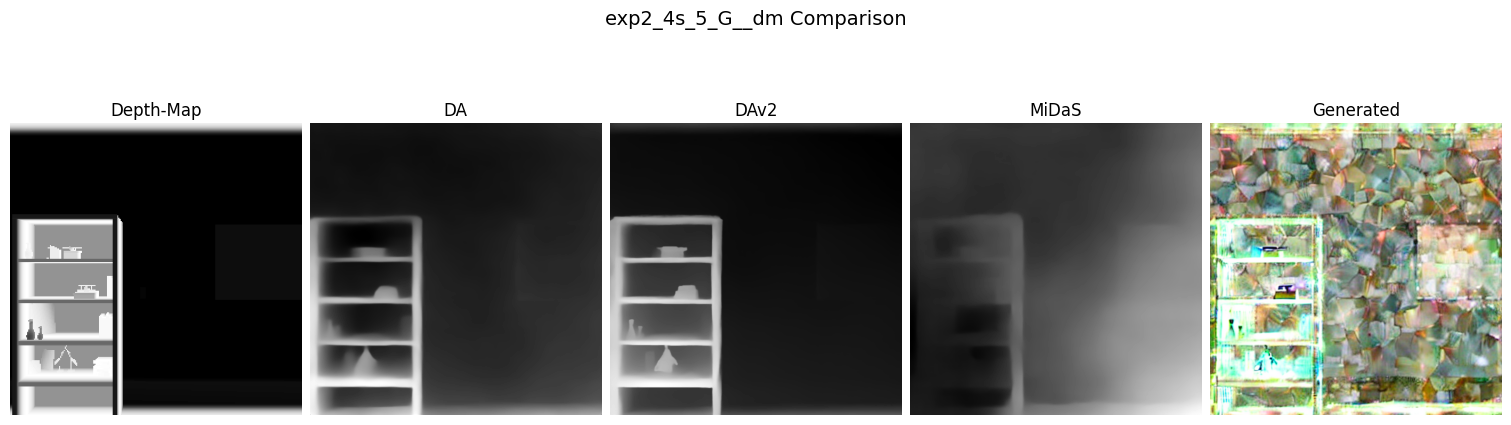

                 Quantitative Metrics                 
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃             exp2_4s_5_G__dm              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━│
│ NRMSE ↓ │     0.781     │      0.671       │ 1.120 │
│ SSIM ↑  │     0.117     │      0.234       │ 0.092 │
│ PSNR ↑  │    10.440     │      11.762      │ 7.303 │
│MANIQA ↑ │                  0.233                   │
└─────────┴──────────────────────────────────────────┘

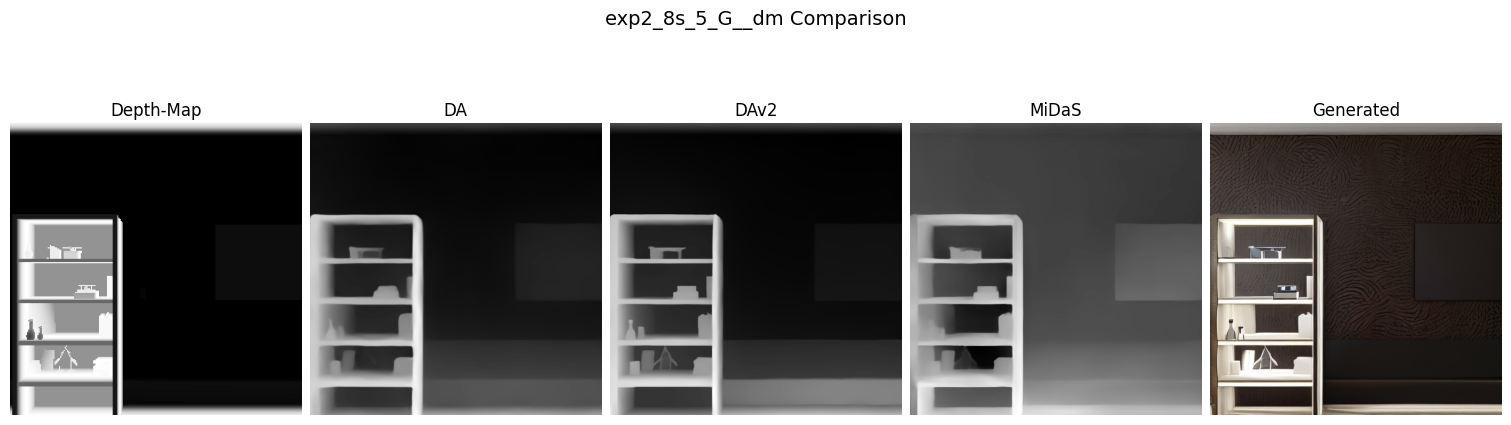

                 Quantitative Metrics                 
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃             exp2_8s_5_G__dm              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━│
│ NRMSE ↓ │     0.717     │      0.739       │ 0.889 │
│ SSIM ↑  │     0.193     │      0.249       │ 0.128 │
│ PSNR ↑  │    11.181     │      10.922      │ 9.315 │
│MANIQA ↑ │                  0.430                   │
└─────────┴──────────────────────────────────────────┘

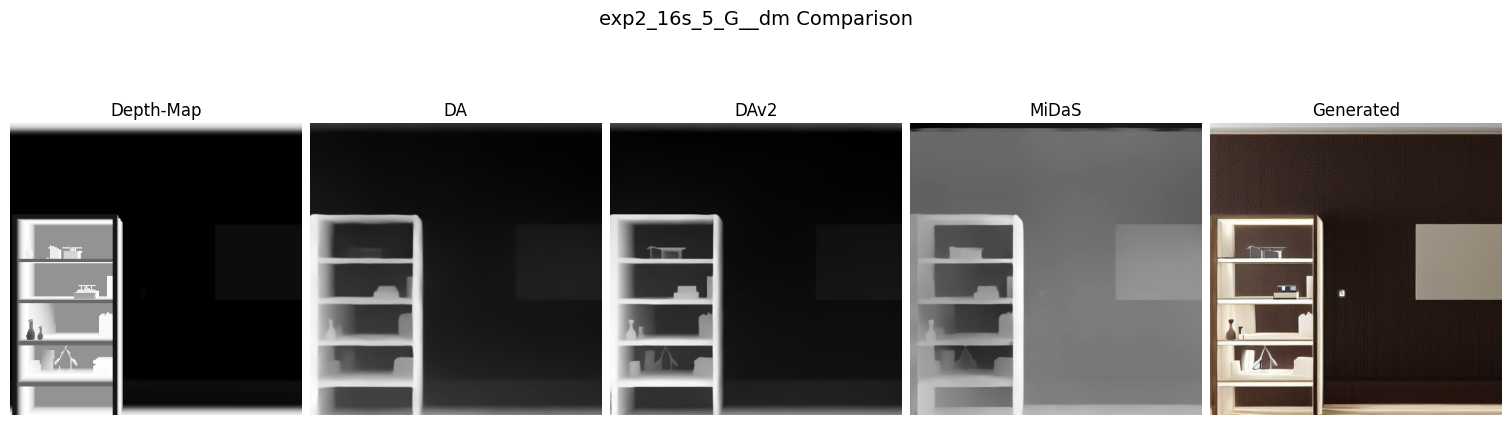

                 Quantitative Metrics                 
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃             exp2_16s_5_G__dm             ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━│
│ NRMSE ↓ │     0.697     │      0.708       │ 1.113 │
│ SSIM ↑  │     0.209     │      0.277       │ 0.124 │
│ PSNR ↑  │    11.420     │      11.289      │ 7.362 │
│MANIQA ↑ │                  0.410                   │
└─────────┴──────────────────────────────────────────┘

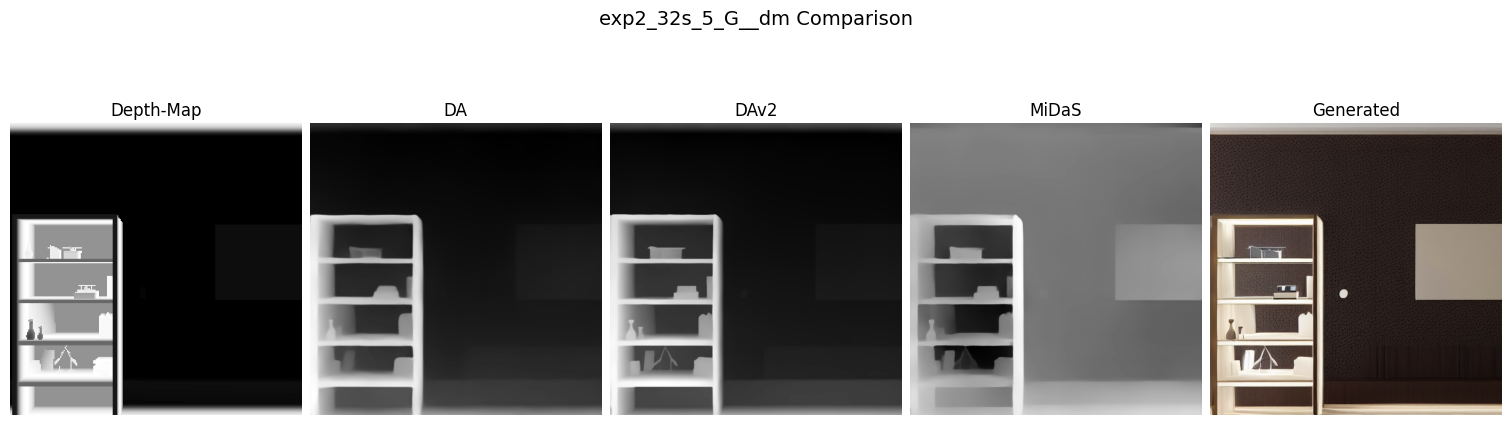

                 Quantitative Metrics                 
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃             exp2_32s_5_G__dm             ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━│
│ NRMSE ↓ │     0.699     │      0.675       │ 1.183 │
│ SSIM ↑  │     0.227     │      0.229       │ 0.101 │
│ PSNR ↑  │    11.397     │      11.706      │ 6.833 │
│MANIQA ↑ │                  0.425                   │
└─────────┴──────────────────────────────────────────┘

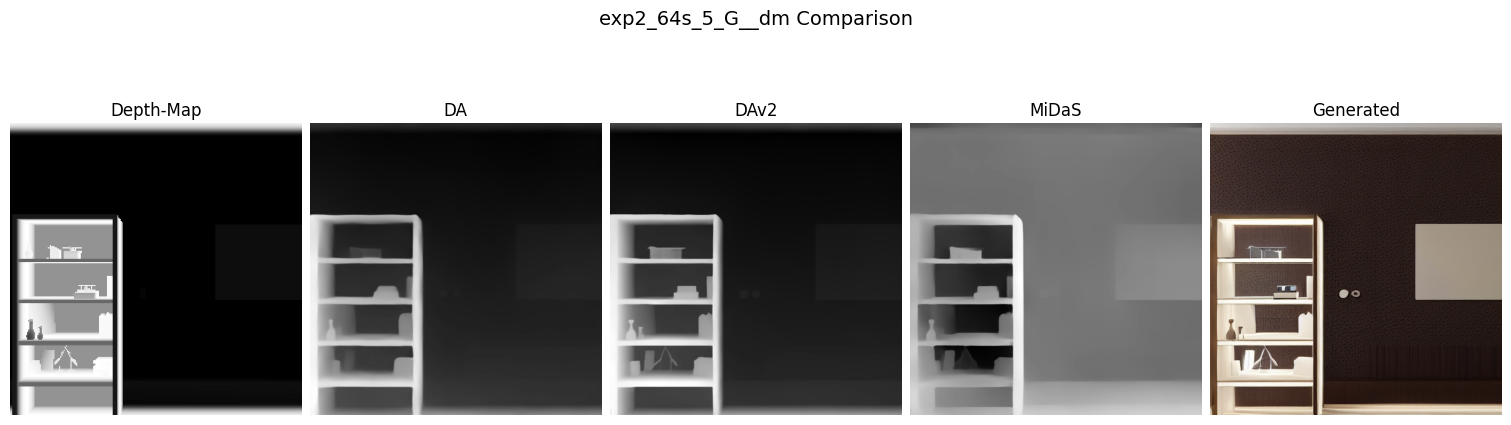

                 Quantitative Metrics                 
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃             exp2_64s_5_G__dm             ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━│
│ NRMSE ↓ │     0.713     │      0.691       │ 1.178 │
│ SSIM ↑  │     0.178     │      0.203       │ 0.095 │
│ PSNR ↑  │    11.232     │      11.494      │ 6.865 │
│MANIQA ↑ │                  0.441                   │
└─────────┴──────────────────────────────────────────┘

In [11]:
display_results(exp_root, exp_name="lesssteps/2s")
display_results(exp_root, exp_name="lesssteps/4s")
display_results(exp_root, exp_name="lesssteps/8s")
display_results(exp_root, exp_name="lesssteps/16s")
display_results(exp_root, exp_name="lesssteps/32s")
display_results(exp_root, exp_name="lesssteps/64s")

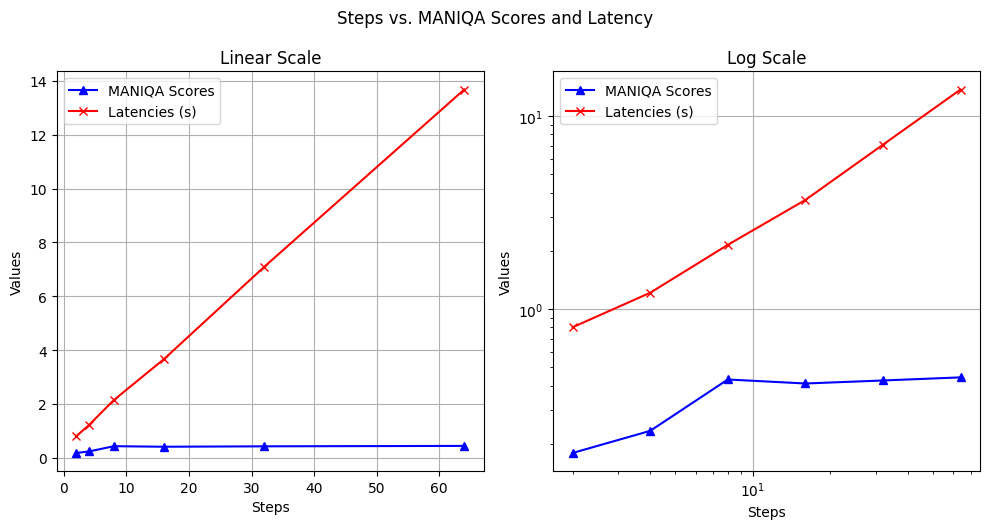

In [12]:
# Scatter plot of steps vs. MANIQA scores and latency
steps = [2, 4, 8, 16, 32, 64]
maniqa_scores = [0.179, 0.233, 0.430, 0.410, 0.425, 0.441]
latencies = [0.8021, 1.2106, 2.1438, 3.6635, 7.0857, 13.6803]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(steps, maniqa_scores, "b", marker="^", label="MANIQA Scores")
axs[0].plot(steps, latencies, "r", marker="x", label="Latencies (s)")
axs[0].set_xlabel("Steps")
axs[0].set_ylabel("Values")
axs[0].set_title("Linear Scale")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(steps, maniqa_scores, "b", marker="^", label="MANIQA Scores")
axs[1].plot(steps, latencies, "r", marker="x", label="Latencies (s)")
axs[1].set_xlabel("Steps")
axs[1].set_ylabel("Values")
axs[1].set_title("Log Scale")
axs[1].grid(True)
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].legend()

plt.tight_layout()
plt.suptitle("Steps vs. MANIQA Scores and Latency", y=1.05)

plt.savefig(exp_root / "steps_vs_quality_and_latency.png", bbox_inches="tight")
plt.show()

### 

## Takeaways
* More preprocessors add to the overall latency.
* Using quantized, low-rank approximations of the ControlNet models can significantly reduce latency, with minimal impact on generated image quality.
* Using pruned models can further reduce latency, with a slight impact on image quality. From above, it is also evident that the pruned checkpoint has a higher throughput than the base checkpoint (in terms of sampling latency).
* On reducing the number of sampling steps:
    * The latency reduces near-linearly, with a corresponding dip in image quality.
    * The generation quality plateaus after a certain number of steps (e.g., ~8-16 steps for `5_G.png`). 
    * With more steps, the adherence to the depth-control shows a slight decrease, but the overall image quality remains consistent.
* Overall savings in latency, compared to the aforementioned baseline, are reported below. Note that this does not include a constant overhead (~3s) from some other nodes that were held unchanged:

    | Process                      | Complete Workflow (s)   | Optimized Workflow (s)  | Savings (%)    |
    |:-----------------------------|:-----------------------:|:-----------------------:|:--------------:|
    | CheckpointLoaderSimple       | 2.9391                  | 1.5723         | 46.51          |
    | ControlNetLoader             | 0.2651                  | 0.0039         | 98.53          |
    | ControlNetApplyAdvanced      | 0.0013                  | 0.0008         | 38.46          |
    | CR Multi-ControlNet Stack    | 0.9322                  | 0.0114         | 98.78          |
    | CR Multi-ControlNet Stack    | 1.2387                  | 0.0107         | 99.14          |
    | CR Apply Multi-ControlNet    | 0.001                   | 0.0005         | 50.00          |
    | KSamplerAdvanced             | 6.5851                  | 2.3723         | 63.99          |
    | VAEDecode                    | 0.2016                  | 0.1027         | 49.06          |
    | **Total**                    | **12.1641**             | **4.0746**     | **66.50**      |